Index([8169], dtype='int64')
Retrieved_Images


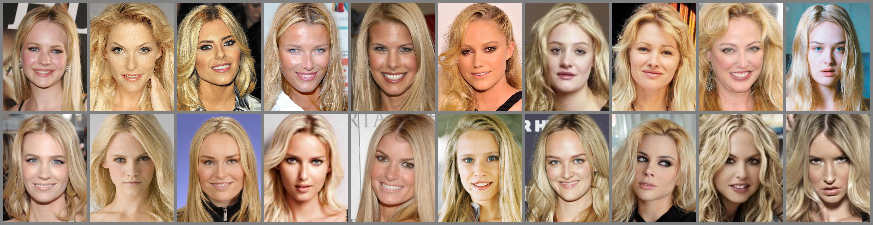

      Image_Index  Gender Hair_Color Hair_Type
8169       187666  female      blond  straight
      Image_Index  Gender Hair_Color Hair_Type
6309       145062  female      blond  straight
466         11050  female      blond      wavy
5184       119341  female      blond      wavy
8537       195698  female      blond       NaN
5354       122749  female      blond       NaN
6818       156711  female      blond      wavy
5318       121846  female      blond       NaN
6376       146648  female      blond      wavy
3251        73820  female      blond      wavy
7691       176327  female      blond      wavy
1861        41183  female      blond      wavy
7259       167202  female      blond      wavy
5974       136743  female      blond  straight
5039       115601  female      blond       NaN
4471       102503  female      blond  straight
4314        98837  female      blond  straight
7480       172491  female      blond      wavy
2785        62847  female      blond      wavy
6496       14

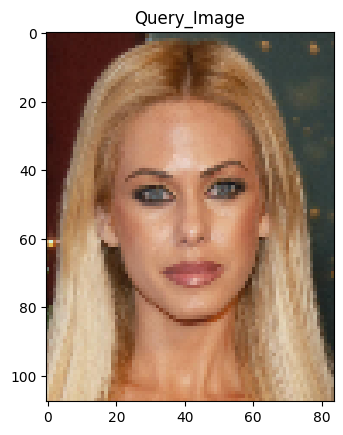

In [23]:
#Retrieves similar images and displays it
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image


image_path='/Users/nimisha/Downloads/Tiny_Portraits_Images/' #path to dataset
csv_path='../data/Tiny_Portraits_Attributes_Test.csv'
feature_path='../../saved_models/HC_features.hdf5'

########Retrieval algorithm
"""
Calculates the euclidean distance between features and sorts in ascending order of distance
Then retuns the images with lower distance
"""
def euclidean(a, b):   
    return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, index_feature, maxResults=64):
    results = []
    for i in range(0, len(index["Image_Index"])):
        d = euclidean(queryFeatures, index[index_feature][i])
        results.append((d,i, index["Image_Index"][i]))
        results = sorted(results)[:maxResults]    
    return results

def Load_Image_Info(index):
    file_name = np.array([image_path + 
                              'Tiny_Portrait_{:06d}.png'.format(idx) for idx in index])
    
    return file_name

#######################
#Read the csv file and sample a Query image with the hair color specified 

df=pd.read_csv(csv_path)
df.dropna(subset=["Hair_Color"], inplace=True)
#Load the features that can be used for retrieval
index_dict={}
with h5py.File(feature_path, "r") as f:
    index_dict["pool_features"]=f["pool_features"][()]
f.close()
index_dict["Image_Index"] = df.Image_Index.values


# Set up how many images to retrive and which feature to use for retrieval

df.reset_index(drop=True, inplace=True)
s=df.Hair_Color[df.Hair_Color.eq('blond')].sample(1).index
print(s)
Query_Index=s

MAX_RESULTS = 21
index_feature="pool_features"
queryFeatures = index_dict[index_feature][Query_Index]
results = perform_search(queryFeatures, index_dict, index_feature, maxResults=MAX_RESULTS)


image_indexes=[]
ids=[]
for i in range(1,len(results)):
    _,a,b=results[i]
    image_indexes.append(b)
    ids.append(a)



##################### Set up for plotting the retrived images
# Image parameters

img_width  = 84
img_height = 108

# Grid parameters
# These define the dimensions of the mosaic,
# as well as the color and thickness of the grid

# Number of rows
num_rows = 2

# Number of columns
num_cols =10

# Grid width in pixels
grid_width = 3

# Grid color
grid_color = (128, 128, 128)

mosaic_width  = grid_width + (img_width  + grid_width) * num_cols
mosaic_height = grid_width + (img_height + grid_width) * num_rows

mosaic = Image.new('RGB', (mosaic_width, mosaic_height), grid_color)
mosaic_index = image_indexes

# Find the image file names as a 2D array
mosaic_files = Load_Image_Info(mosaic_index)
mosaic_files = mosaic_files.reshape((num_rows, num_cols))

# Load and insert

for row in range(num_rows):
    for col in range(num_cols):
        
        # Load image
        thumbnail = Image.open(mosaic_files[row, col])
        
        # Insert image
        top_left_x = grid_width + (img_width  + grid_width) * col
        top_left_y = grid_width + (img_height + grid_width) * row
        
        mosaic.paste(thumbnail, box = (top_left_x, top_left_y))
        
plt.imshow(Image.open(os.path.join(image_path,'Tiny_Portrait_{:06d}.png'.format(index_dict["Image_Index"][Query_Index][0]))))
plt.title('Query_Image')
print('Retrieved_Images')
display(mosaic)


print(df.loc[s])
print(df.loc[ids])

/Users/nimisha/Library/Caches/pypoetry/virtualenvs/gender-classifier-Cc5HoRu0-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nimisha/Library/Caches/pypoetry/virtualenvs/gender-classifier-Cc5HoRu0-py3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


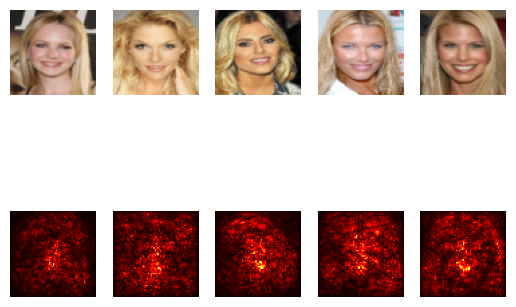

In [24]:
#Saliency map to see what the model learned

import torch
from skimage import io
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from debiased_classifier.code.model import Network
import torch.nn as nn
from debiased_classifier.code.dataset import general_transforms
###Choose the Hair color/ gender model path to visualize the features
model_path='../../saved_models/best_Hair_Color.pth'

def Saliency(model, X):
     
    for param in model.parameters():
        param.requires_grad = False
   
    model.eval()
    X.requires_grad = True   
    preds = model(X)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(X.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())    
    return slc

# Number of classes is 5 for hair color and 2 for gender 
model=Network(classes=5)
model.to('cpu')
model.load_state_dict(torch.load(model_path))
img_size=64
transform=general_transforms(img_size)
fig, axs = plt.subplots(2, 5)
for count,i in enumerate(image_indexes[0:5]):
    X = transform(io.imread(os.path.join(image_path,'Tiny_Portrait_{:06d}.png'.format(i)))).to('cpu') 
    salmap=Saliency(model, X.unsqueeze(0))
    axs[0,count].imshow(X.cpu().numpy().transpose((1, 2, 0)))
    axs[0,count].axis('off')
    axs[1,count].imshow(salmap.cpu(),cmap=plt.cm.hot)
    axs[1,count].axis('off')